In [232]:
#!pip install wordcloud
#!pip install -U nltk
#!python -m spacy download da_core_news_md

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re
import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize.treebank import TreebankWordDetokenizer
#nltk.download('perluniprops')
import spacy
from spacy import displacy
nlp = spacy.load('da_core_news_md')
from collections import Counter

from function import *

## Scraping KU, AU and AAU

In [3]:
ku_list = []

# List of subjects we want to scrape data from 
search_list = ['psykologi', 'sociologi', 'statskundskab', 'antropologi', 'oekonomi']

# Extracting data from University of Copenhagen
for k in search_list:
    soup = extract_ku(k)
    ku_list.append(transform_ku(soup))

ku_df = pd.DataFrame(data=ku_list)

# Merging the two colums 
ku_df=ku_df[0]+ku_df[1]

# Making the object a DataFrame
ku_df=pd.DataFrame(ku_df)

# Transposing the DataFrame 
ku_df=pd.DataFrame.transpose(ku_df)

# Naming the columns in DataFrame
ku_df.columns=['cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', 'cand.oecon_ku']

In [4]:
soup = extract_au('statskundskab')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_stats = text[75:77]

stats_df = pd.DataFrame(data=text_stats, columns=['cand.scient.pol_au'])
stats = pd.DataFrame([', '.join(stats_df['cand.scient.pol_au'].to_list())], columns=['cand.scient.pol_au'])

In [5]:
soup = extract_au('oekonomi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_oek = text[60:62]

oek_df = pd.DataFrame(data=text_oek, columns=['cand.oecon_au'])
oek = pd.DataFrame([', '.join(oek_df['cand.oecon_au'].to_list())], columns=['cand.oecon_au'])

In [6]:
soup = extract_au('antropologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_ant = text[50:55]

ant_df = pd.DataFrame(data=text_ant, columns=['cand.scient.anth_au'])
ant = pd.DataFrame([', '.join(ant_df['cand.scient.anth_au'].to_list())], columns=['cand.scient.anth_au'])

In [7]:
soup = extract_au('psykologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_psyk = text[74:78]

psyk_df = pd.DataFrame(data=text_psyk, columns=['cand.psych_au'])
psyk = pd.DataFrame([', '.join(psyk_df['cand.psych_au'].to_list())], columns=['cand.psych_au'])

In [8]:
frames = [ant, stats, psyk, oek]

au_df = pd.concat(frames, axis=1)

au_df_list = au_df['cand.scient.anth_au'].to_list()
au_list = []

for i in au_df_list:
    au_list.append(clean_text(i))


In [9]:
def transform_aau(soup):

    divs = soup.find_all("main", class_="Main_Main__2KIvG")

    for item in divs:
        text_aau = item.find_all()[0].text.strip()

        aau_text = {
            "text_aau" : text_aau, 
        }
        aau_list.append(aau_text)

        text_aau = clean_text(text_aau)
        
    return text_aau

aau_list = []

search_list = ['psykologi', 'sociologi', 'oekonomi']

for k in search_list:
    try: 
        soup = extract_aau(k)
        transform_aau(soup)
    except:
        break

aau_df = pd.DataFrame(data=aau_list)

aau_df=pd.DataFrame.transpose(aau_df)

aau_df.columns=['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau']

aau_df = aau_df.reset_index(drop=True)

aau_df

,cand.psych_aau,cand.scient.soc_aau,cand.oecon_aau
0,KandidatPsykologiUddannelsen uddanner dig til ...,KandidatSociologiUddannelsen bygger videre på ...,KandidatØkonomiDu lærer at analysere samfundsø...


## Combining Dataframes

In [10]:
merge_frames = [ku_df, au_df, aau_df]

combined_df = pd.concat(merge_frames, axis=1)

combined_df['cand.psych_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.psych_ku']]
combined_df['cand.scient.pol_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.pol_ku']]
combined_df['cand.oecon_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.oecon_ku']]
combined_df['cand.scient.anth_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.anth_ku']]
combined_df['cand.scient.soc_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.soc_ku']]

combined_df['cand.psych'] = combined_df['cand.psych_aau'] + combined_df['cand.psych_au'] + combined_df['cand.psych_ku_string']
combined_df['cand.scient.anth'] = combined_df['cand.scient.anth_au'] + combined_df['cand.scient.anth_ku_string']
combined_df['cand.scient.pol'] = combined_df['cand.scient.pol_au'] + combined_df['cand.scient.pol_ku_string']
combined_df['cand.scient.soc'] = combined_df['cand.scient.soc_aau'] + combined_df['cand.scient.soc_ku_string']
combined_df['cand.oecon'] = combined_df['cand.oecon_aau'] + combined_df['cand.oecon_au'] + combined_df['cand.oecon_ku_string']

In [11]:
combined_df.drop(['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau', 'cand.psych_au', \
                  'cand.scient.anth_au', 'cand.scient.pol_au','cand.oecon_au', \
                  'cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', \
                  'cand.oecon_ku', 'cand.psych_ku_string', 'cand.scient.pol_ku_string', 'cand.oecon_ku_string', \
                  'cand.scient.anth_ku_string', 'cand.scient.soc_ku_string'], axis=1, inplace=True)

In [12]:
university_df = combined_df
university_df

,cand.psych,cand.scient.anth,cand.scient.pol,cand.scient.soc,cand.oecon
0,KandidatPsykologiUddannelsen uddanner dig til ...,Dine jobmuligheder som antropolog afhænger meg...,Som bachelor i Statskundskab bliver du først o...,KandidatSociologiUddannelsen bygger videre på ...,KandidatØkonomiDu lærer at analysere samfundsø...


## Scraping UG

In [13]:
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]

In [14]:
psych = clean_text(extract_UG(education_url[0][0]))
oecon = extract_UG(education_url[1][0])
pol = extract_UG(education_url[2][0])
anth = extract_UG(education_url[3][0])
soc = extract_UG(education_url[4][0])

## Combining skills from UG and Universities

In [15]:
strings_psych = psych + university_df['cand.psych']
strings_oecon = oecon + university_df['cand.oecon']
strings_pol = pol + university_df['cand.scient.pol']
strings_anth = anth + university_df['cand.scient.anth']
strings_soc = soc + university_df['cand.scient.soc']


psych_comb = " ".join(strings_psych)
oecon_comb = " ".join(strings_oecon)
pol_comb = " ".join(strings_pol)
anth_comb = " ".join(strings_anth)
soc_comb = " ".join(strings_soc)

In [16]:
psych_series = pd.Series(psych_comb)
oecon_series = pd.Series(oecon_comb)
pol_series = pd.Series(pol_comb)
anth_series = pd.Series(anth_comb)
soc_series = pd.Series(soc_comb)

psych_df = pd.DataFrame(psych_series)
oecon_df = pd.DataFrame(oecon_series)
pol_df = pd.DataFrame(pol_series)
anth_df = pd.DataFrame(anth_series)
soc_df = pd.DataFrame(soc_series)

psych_df['cand.psych'] = psych_df[0]
oecon_df['cand.oecon'] = oecon_df[0]
pol_df['cand.scient.pol'] = pol_df[0]
anth_df['cand.scient.anth'] = anth_df[0]
soc_df['cand.scient.soc'] = soc_df[0]

In [17]:
final_df = pd.concat([psych_df['cand.psych'], oecon_df['cand.oecon'], pol_df['cand.scient.pol'], \
                      anth_df['cand.scient.anth'], soc_df['cand.scient.soc']], axis=1)

final_df = make_a_list(final_df['cand.psych']).append(make_a_list(final_df['cand.oecon'])).append(make_a_list(final_df['cand.scient.pol']))\
    .append(make_a_list(final_df['cand.scient.anth'])).append(make_a_list(final_df['cand.scient.soc']))

final_df = final_df.T
final_df.columns = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']
final_df

,cand.psych,cand.oecon,cand.scient.pol,cand.scient.anth,cand.scient.soc
0,på kandidatuddannelsen arbejder du videnskabe...,på kandidatuddannelsen får du en udvidet fors...,du får analytiske færdigheder og teoretisk in...,du fortsætter studiet af menneskers sociale o...,du vil herunder få specialiseret viden om de ...


In [18]:
token_psych = final_df['cand.psych'].apply(word_tokenize)
token_oecon = final_df['cand.oecon'].apply(word_tokenize)
token_pol = final_df['cand.scient.pol'].apply(word_tokenize)
token_anth = final_df['cand.scient.anth'].apply(word_tokenize)
token_soc = final_df['cand.scient.soc'].apply(word_tokenize)

In [19]:
stop = stopwords.words('danish')
final_psych = token_psych.apply(lambda words: [word for word in words if word not in stop])
final_oecon = token_oecon.apply(lambda words: [word for word in words if word not in stop])
final_pol = token_pol.apply(lambda words: [word for word in words if word not in stop])
final_anth = token_anth.apply(lambda words: [word for word in words if word not in stop])
final_soc = token_soc.apply(lambda words: [word for word in words if word not in stop])

In [208]:
psych_df = final_psych.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
l_psych = psych_df.values.tolist()

oecon_df = final_oecon.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
l_oecon = oecon_df.values.tolist()

pol_df = final_pol.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
l_pol = pol_df.values.tolist()

anth_df = final_anth.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
l_anth = anth_df.values.tolist()

soc_df = final_soc.apply(lambda x: TreebankWordDetokenizer().detokenize(x))
l_soc = soc_df.values.tolist()

In [209]:
write_text('cand.psych', l_psych)
write_text('cand.oecon', l_oecon)
write_text('cand.scient.pol', l_pol)
write_text('cand.scient.anth', l_anth)
write_text('cand.scient.soc', l_soc)

In [241]:
document = nlp(open('/Users/emiliemelchior/Desktop/ISDS-kopi/Exam/cand.psych.txt',
encoding="utf-8").read())
adjs = []
for token in document:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        token.text
adjs
adjs_tally_psych = Counter(adjs)
#adjs_tally_psych.most_common()

In [242]:
f_psych = ' '.join(map(str, adjs_tally_psych))

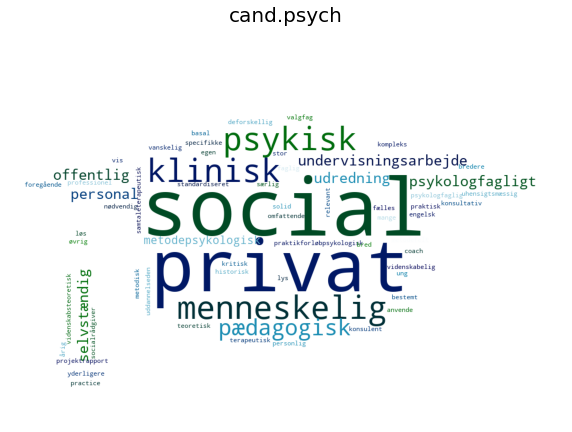

In [272]:
# Silhouette of our WordCloud picture
study_mask = np.array(Image.open('/Users/emiliemelchior/Desktop/hat.png'))

# Updated StopWords containing words that should not be included in the analysis
stopwords2 = set(STOPWORDS)
stopwords2.update(['hr','bringe','ppr','vores','ønsker','nye','hverdag','del','inden','søger', 
'kan','egedal','oktober','kompetencer','li','ul','text','align','justify','br','p','div','strong',
'style','href','både', 'psykologi', 'pensum', 'sider', 'kandidatuddannelsen', 'studerende', 'mindst', 'dine', 'psykolog', 'psykologiske',
'psykologisk', 'optagelse', 'uddannelse', 'semester', 'dit', 'uddannelsen', 'fx', 'får', 'meget', 'psykologisk', 'god', 'arbejds', 'enkelt',
'forsk', 'forskellig', 'undervis', 'hrefhttps', 'høj'])

# Function to design the WordCloud
def generate_better_wordcloud(data, title, mask=None):
    cloud = WordCloud(scale=3,
                      max_words=100, #Maximum words in the WordCloud
                      colormap='ocean', #Color of the WordCloud
                      mask=mask,
                      background_color='white',
                      stopwords=stopwords2, #Setting StopWords equal to the updated
                      collocations=True).generate(data)
    plt.figure(figsize=(10,10))
    plt.imshow(cloud)
    plt.axis('off') #No axis 
    plt.title(title, fontsize=20) #Title
    plt.show()

    
generate_better_wordcloud(f_psych, 'cand.psych', mask=study_mask)

In [258]:
document = nlp(open('/Users/emiliemelchior/Desktop/ISDS-kopi/Exam/cand.oecon.txt',
encoding="utf-8").read())
adjs = []
for token in document:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        token.text
adjs
adjs_tally_oecon = Counter(adjs)
#adjs_tally_oecon.most_common()

In [259]:
f_oecon = ' '.join(map(str, adjs_tally_oecon))

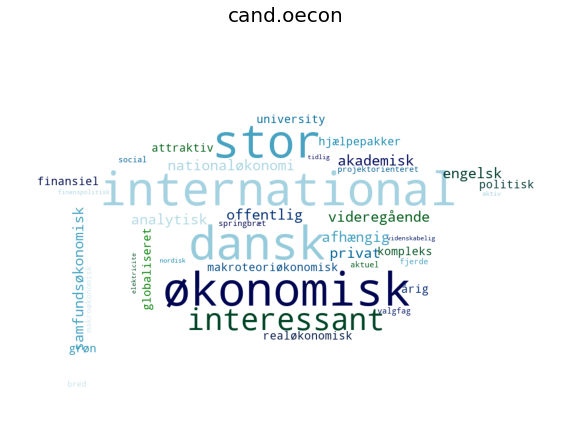

In [260]:
#wordcloud = WordCloud(stopwords=stopwords2, max_font_size=35, max_words=80, background_color='white').generate(f_oecon)
#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

generate_better_wordcloud(f_oecon, 'cand.oecon', mask=study_mask)

In [261]:
document = nlp(open('/Users/emiliemelchior/Desktop/ISDS-kopi/Exam/cand.scient.pol.txt',
encoding="utf-8").read())
adjs = []
for token in document:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        token.text
adjs
adjs_tally_pol = Counter(adjs)
#adjs_tally_pol.most_common()

In [262]:
f_pol = ' '.join(map(str, adjs_tally_pol))

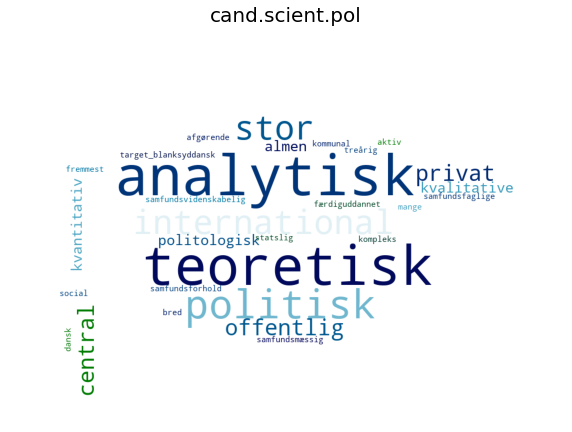

In [263]:
#wordcloud = WordCloud(stopwords=stopwords2, max_font_size=40, max_words=80, background_color='white').generate(f_pol)

#plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis('off')
#plt.show()

generate_better_wordcloud(f_pol, 'cand.scient.pol', mask=study_mask)

In [264]:
document = nlp(open('/Users/emiliemelchior/Desktop/ISDS-kopi/Exam/cand.scient.anth.txt',
encoding="utf-8").read())
adjs = []
for token in document:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        token.text
adjs
adjs_tally_anth = Counter(adjs)
#adjs_tally_anth.most_common()

In [265]:
f_anth = ' '.join(map(str, adjs_tally_anth))

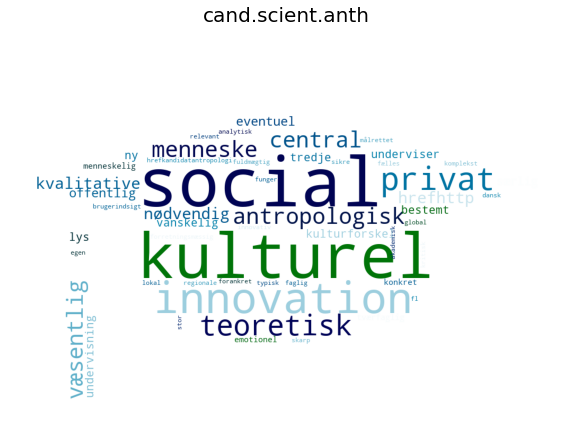

In [266]:
generate_better_wordcloud(f_anth, 'cand.scient.anth', mask=study_mask)

In [267]:
document = nlp(open('/Users/emiliemelchior/Desktop/ISDS-kopi/Exam/cand.scient.soc.txt',
encoding="utf-8").read())
adjs = []
for token in document:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
        token.text
adjs
adjs_tally_soc = Counter(adjs)
#adjs_tally_soc.most_common()

In [268]:
f_soc = ' '.join(map(str, adjs_tally_soc))

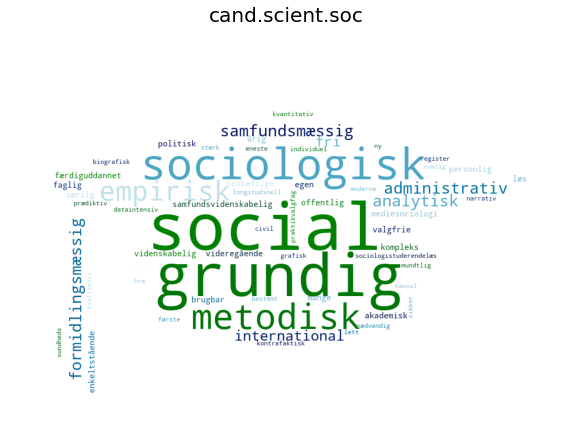

In [269]:
generate_better_wordcloud(f_soc, 'cand.scient.soc', mask=study_mask)

In [279]:
print('Psychology:', len(adjs_tally_psych))
print('Economics:', len(adjs_tally_oecon))
print('Political Science:', len(adjs_tally_pol))
print('Athropology:', len(adjs_tally_anth))
print('Sociology:', len(adjs_tally_soc))

Psychology: 162
Economics: 90
Political Science: 35
Athropology: 56
Sociology: 138
